# 0.01 - 0.05 redshift bin - Schechter no redshift dependence & GMM comparison

In [1]:
import copy
import os
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

### Methods

#### Mass completeness limit

In [3]:
def mass_completeness_limit(z):
    f, b, c = [-1.34199453, 13.90578909,  8.53522654]
    return 4*np.pi*f*z**2 + b*z + c

#### Mass completeness limit inverse

In [4]:
def zmax_mass_completeness_limit(m):
    f, b, c = [-1.34199453, 13.90578909, 8.53522654]

    discriminant = -16*np.pi*f*c + 16*np.pi*f*m + b**2
    sqrt_discriminant = np.sqrt(discriminant)

    z1 = (-b + sqrt_discriminant) / (8 * np.pi * f)
    
    return z1

#### Selecting data (TODO polish)

In [5]:
def gathering_data(data, zmin, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec, vmax

#### Schechter function (no redshift dependence)

In [6]:
# For Emcee fit
def smf_single_schechter_sty(x, logM, alpha1):
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


# def smf_single_schechter_sty(x, logM, alpha1):
    
#     term0 = np.exp(-10 ** (x-logM[:,None]))
#     term1 = 10 ** ((alpha1+1)[:,None]*(x - logM[:,None]))
#     return term0 * term1

#### Log Likelihood - prior - posterior

In [7]:
def log_likelihood(logM, alpha1, w, x, z):
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    q = smf_single_schechter_sty(x, logM, alpha1)
    a = np.log10(np.sum(q, axis=1)) - np.log10(I)
    return a * w


def log_prior(theta):
    logM, alpha1 = theta
    if 9.5 < logM < 13.5 and \
        -5. < alpha1 < 0. :
        return 0
    return -np.inf



def posterior(theta, w, x, z):
    logM, alpha1 = theta
    l = log_likelihood(logM, alpha1, w, x, z)
    return log_prior(theta) + np.sum(l)

#### Normalisation

In [8]:
def v_tot(f_area, z):
    v_min = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area
    v_max = Planck13.comoving_volume(z).value * Planck13.h**3 * f_area
    return v_max  - v_min



def normalisation(f_area, w_spec, vmax, z, z0, best_params):
    logM, alpha1 = best_params
    
    I = []
    mlim = mass_completeness_limit(z)
    for i in range(z.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])
    
    # return (1/v_tot(f_area,z0))* np.sum(w_spec/np.array(I)) THIS IS THE ONE FROM THE PAPER
    return np.sum(w_spec/np.array(I)/vmax), I


def normalisation_last(bgs, f_area, z0, best_params):
    logM, alpha1 = best_params
    zmin = 0.01

    # z, x, x_median, w_spec, vmax = gathering_data(data, zmin, z0)
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(z0).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / bgs['Vmax'].data
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < z0)& \
                (np.median(bgs['provabgs_logMstar'].data, axis=1) > mass_completeness_limit(bgs['Z_HP'].data))
    
    
    I = []
    mlim = mass_completeness_limit(bgs['Z_HP'].data[zlim])
    for i in range(mlim.shape[0]):
        I.append(integrate.quad(smf_single_schechter_sty, mlim[i], 13., args=(logM, alpha1))[0])

    
    # return (1/v_tot(f_area,z0))* np.sum(w_spec/np.array(I)) THIS IS THE ONE FROM THE PAPER
    return np.sum(w_import[zlim]/np.array(I))/(v_zmax - v_zmin), I

#### Gaussian Mixture Model

In [9]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

## Selecting Data

In [10]:
data_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/data'
data_file = 'BGS_ANY_full.provabgs.lite.hdf5'
path_to_data = os.path.join(data_dir,data_file)

bgs = aTable.Table.read(path_to_data)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]
zmax = 0.05
zmin = 0.01

z_tot, x_tot, x_median_tot, w_spec_tot, v_max_tot = gathering_data(bgs, zmin, 0.4)
z, x, x_median, w_spec, v_max = gathering_data(bgs, zmin, zmax)

In [11]:
z.shape, x_median.shape, w_spec.shape, x.shape, v_max.shape

((3495,), (3495,), (3495,), (3495, 100), (3495,))

### Data plot

(6.0, 13.2)

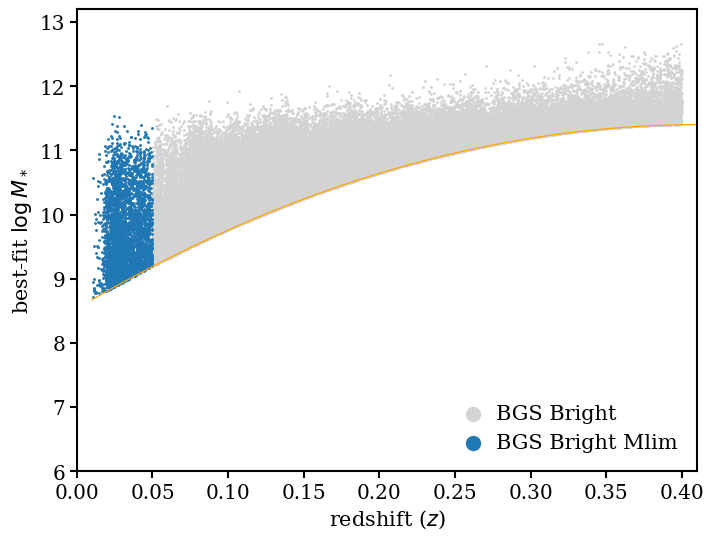

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(z_tot, x_median_tot, 
            s=1, c='lightgrey', label='BGS Bright')

sub.scatter(z, x_median, 
            s=1, c='C0', label='BGS Bright Mlim')


sub.plot(np.linspace(0.01, 0.65), mass_completeness_limit(np.linspace(0.01, 0.65)),
         color = 'orange', linewidth=0.9)


# sub.scatter(pt[problems[0]][:,5], pt[problems[0]][:,4], c='red', s=1)


sub.legend(loc='lower right', fontsize=15, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=15)
sub.set_xlim(0., 0.41)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
sub.set_ylim(6., 13.2)

## Emcee

In [13]:
logM, alpha1 = 10.3, -1.2


theta = [logM, alpha1]
args = (w_spec, x, z)

start = np.array(theta)
nwalkers = 20
nstep = 300
pos = start + 1e-4 * np.random.randn(nwalkers, 2)
nwalkers, ndim = pos.shape

# Initialize the backend to save the chain
filename = "NozSchechter_50w_500step_0.01_0.05_nowspec.h5"
backend = emcee.backends.HDFBackend(filename)



run_emcee = False

if run_emcee:
    # with Pool() as pool: APPARENTLY IF YOU RUN EMCEE IN PARALLEL ON AN INTERACTIVE KERNEL IT DOESN'T WORK
    backend.reset(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=args, backend=backend)
    start_time = time.time()
    sampler.run_mcmc(pos, nstep, progress=True);
    end_time = time.time()
    print("Multiprocessing took {0:.1f} minutes".format((end_time-start_time)/60.))
    print("Multiprocessing took {0:.1f} hours".format((end_time-start_time)/3600.))

### Emcee plots

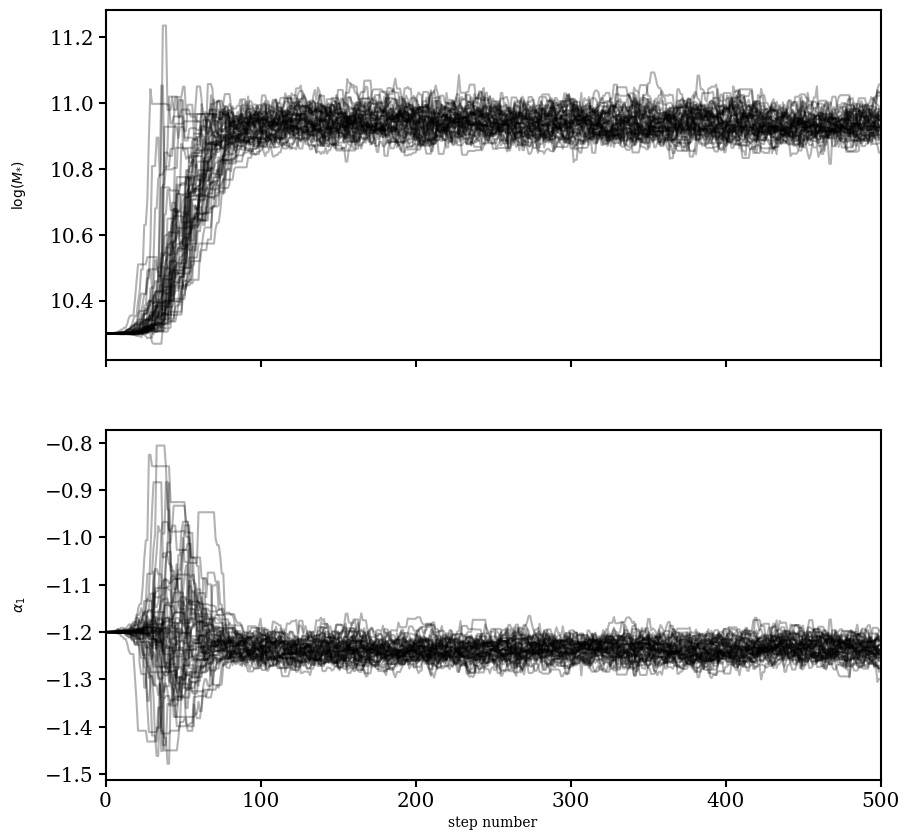

In [14]:
emcee_runs_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/bin_tests_runs'

emcee_run = os.path.join(emcee_runs_dir,filename)
reader = emcee.backends.HDFBackend(emcee_run)
samples = reader.get_chain()

ndim = 2
labels = [r'$\log(M_{*})$', r'$\alpha_{1}$']


fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

# plt.show()
# plt.subplots_adjust(bottom=0.2)

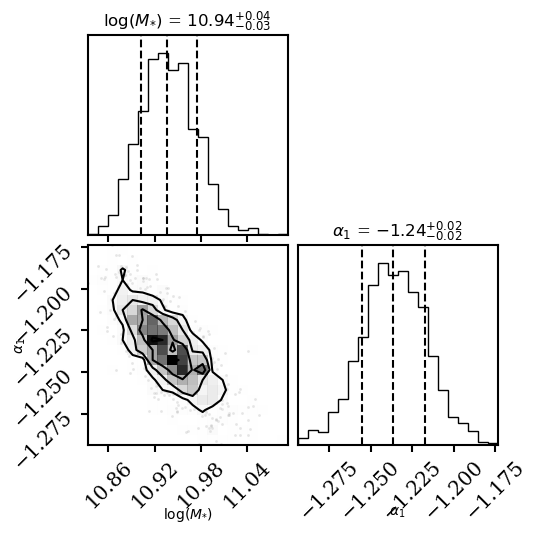

In [15]:
flat_samples = reader.get_chain(discard=100, thin=15, flat=True) 
fig = corner.corner(flat_samples, labels=labels, quantiles=(0.16, 0.50, 0.84), show_titles=True);
plt.show()

In [16]:
mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(flat_samples.shape[1])])
logM_mcmc, alpha1_mcmc = mcmc[:,1]

## Schechter function plots

(8.0, 13.0)

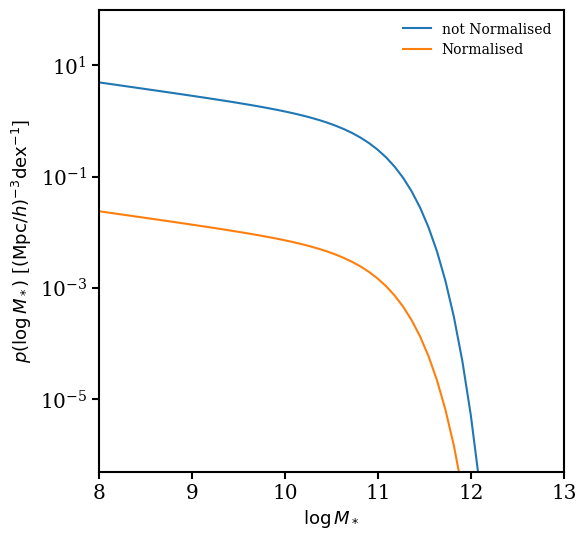

In [17]:
x_lin = np.linspace(7, 16, 100)
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))

n, I = normalisation(f_area, w_spec, v_max, z, zmax, mcmc[:,1])

plt.figure(figsize=(6,6))


plt.plot(x_lin, smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), label='not Normalised')
plt.plot(x_lin, n * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), label='Normalised')

plt.yscale('log')
plt.xlabel(r'$\log M_*$', fontsize=13)
plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=13)
plt.legend(loc='best')
plt.ylim(5e-7, 1e2)
plt.xlim(8,13)

/var/folders/7q/qq4djnwd45n6znblnxh0t64m0000gn/T/ipykernel_12159/1196523095.py:31: RuntimeWarning: divide by zero encountered in divide
  w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin)


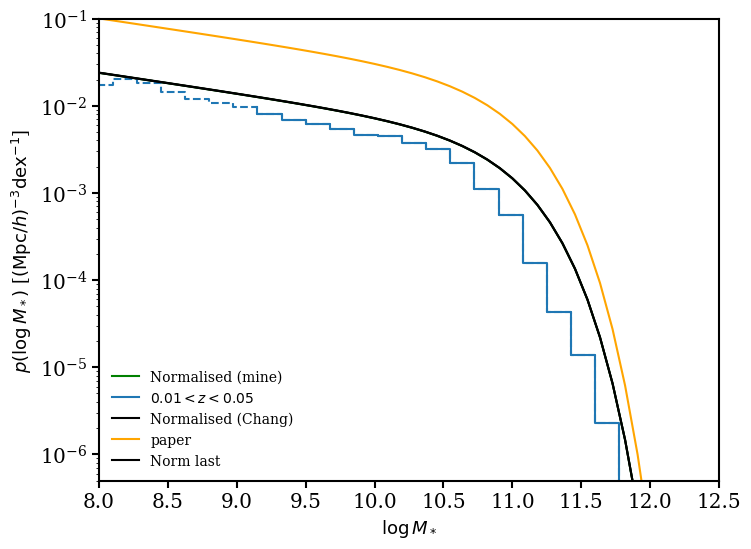

In [18]:
gmm_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/gmm'
gmm_file = 'psmf.gmm.bgs_bright.z0.01_0.05.last.pt'


if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = 'cpu'

# mlim = [8.975, 9.325, 9.5, 9.85, 10.024999999999999, 10.2, 10.375, 10.55, 10.725, 10.725, 10.899999999999999, 
        # 10.899999999999999, 11.075, 11.075, 11.425, 11.425]
# zmins, zmaxs = [0.01], [0.05]

_zmin, _zmax, mlim = np.loadtxt(os.path.join(data_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])
zmins = np.array([0.01 + 0.04 * i for i in range(4)])
zmaxs = np.array([0.05 + 0.04 * i for i in range(4)])


fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.plot(x_lin, n * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), color='green', label='Normalised (mine)')

for i, zmin, zmax in zip(range(1), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    w_import2 = (v_zmax - v_zmin) / (bgs['Vmax'][zlim].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import2 *= bgs['provabgs_w_zfail'][zlim].data * bgs['provabgs_w_fibassign'][zlim]

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    norm2 = np.sum(w_import2) / (v_zmax - v_zmin)
                                    
    #psmf_model = best_models_z[i] 
    psmf_model_last = torch.load(os.path.join(gmm_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    psmf_model = torch.load(os.path.join(gmm_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
        post_prime_last = psmf_model_last.sample((100000,))
    
    # calculate normalization    
    #_ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
    #             weights=w_import[zlim]*norm, #10000./np.sum(w_import[zlim]), 
    #             range=(6., 13.), bins=40, histtype='step', 
    #             color='k', linestyle='--', linewidth=1) 
                       
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)

    h_last, be_last = np.histogram(np.array(post_prime_last.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)

    h2, be2 = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm2, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

    # sub.step(be_last[:-1], h_last, where='pre', color='red', linestyle='--')
    # sub.step(be_last[:-1][be_last[:-1] > mlim[2*i+1]], h_last[be_last[:-1] > mlim[2*i+1]], where='pre', color='red', linestyle='-')
    # sub.plot([], [], c='red', label='$%.2f < z < %.2f$ last' % (zmin, zmax))

    # sub.step(be2[:-1], h2, where='pre', color='orange', linestyle='--')
    # sub.step(be2[:-1][be2[:-1] > mlim[2*i+1]], h2[be2[:-1] > mlim[2*i+1]], where='pre', color='orange', linestyle='-')
    # sub.plot([], [], c='orange', label='$%.2f < z < %.2f$ norm2' % (zmin, zmax))
    
    sub.plot(x_lin, 
             np.sum(w_spec/np.array(I)/(v_max-v_zmin)) * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), color='black', label='Normalised (Chang)')
    sub.plot(x_lin,
             (1/v_tot(f_area,zmax))* np.sum(w_spec/np.array(I))* smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), color='orange', label='paper')

    nn, ii = normalisation_last(bgs, f_area, 0.05, [logM_mcmc, alpha1_mcmc])
    sub.plot(x_lin, nn * smf_single_schechter_sty(x_lin, logM_mcmc, alpha1_mcmc), color='black', label='Norm last')
    
sub.legend(loc='lower left', fontsize=10)
sub.set_xlabel(r'$\log M_*$', fontsize=13)
sub.set_xlim(8., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=13)
sub.set_yscale('log')
sub.set_ylim(5e-7, 1e-1)
plt.show()

In [19]:
n, norm, np.sum(1/np.array(I)/(v_max-v_zmin)), np.sum(1/np.array(I)/(v_tot(f_area,z)))

(0.004840132600727142,
 0.2292625830952788,
 0.00450183751393653,
 0.13627272209913976)